In [ ]:
pip install tensorflow

In [ ]:
import os
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from pathlib import Path
from PIL import Image

In [ ]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# Check TensorFlow version and GPU device
print(f'TensorFlow version: {tf.__version__}')
print(f'GPU device: {tf.config.list_physical_devices("GPU")}')

GPU found
TensorFlow version: 2.15.0
GPU device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
tf.device('/device:GPU:0')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = Path("/content/drive/MyDrive/Garbage classification")

In [ ]:
print(data_dir)

/content/drive/MyDrive/Garbage classification


In [ ]:
if os.path.exists(data_dir):
    classes = os.listdir(data_dir)
    print(classes)
else:
    print(f"The directory '{data_dir}' does not exist.")

['metal', 'cardboard', 'paper', 'glass', 'plastic', 'trash']


/content/drive/MyDrive/Garbage classification/glass/glass105.jpg


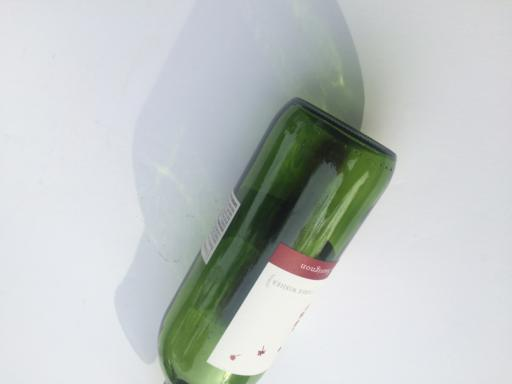

In [ ]:
glass = list(data_dir.glob('glass/*'))
print(glass[0])
PIL.Image.open(str(glass[0]))

In [ ]:
metal = list(data_dir.glob('metal/*'))
cardboard = list(data_dir.glob('cardboard/*'))
paper = list(data_dir.glob('paper/*'))
plastic = list(data_dir.glob('plastic/*'))
trash = list(data_dir.glob('trash/*'))

In [ ]:
PIL.Image.open(str(glass[8])).size

(512, 384)

In [ ]:
# Define the classes
classes = ['glass', 'metal', 'cardboard', 'paper', 'plastic', 'trash']

# Iterate through each class
for class_name in classes:
    class_images = list(data_dir.glob(f'{class_name}/*'))

    # Check if there are any images in the class
    if class_images:
        # Get the first image in the class
        first_image_path = class_images[0]

        # Print the size of the first image in the class
        img = Image.open(str(first_image_path))
        width, height = img.size
        print(f"Class: {class_name}, First Image: {first_image_path.name}, Size: {width} x {height}")
    else:
        print(f"No images found for class: {class_name}")

Class: glass, First Image: glass105.jpg, Size: 512 x 384
Class: metal, First Image: metal114.jpg, Size: 512 x 384
Class: cardboard, First Image: cardboard118.jpg, Size: 512 x 384
Class: paper, First Image: paper127.jpg, Size: 512 x 384
Class: plastic, First Image: plastic108.jpg, Size: 512 x 384
Class: trash, First Image: trash91.jpg, Size: 512 x 384


In [ ]:
img_height, img_width = 180, 180
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = "training",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size= batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = "validation",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size= batch_size
)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
# net = models.resnet18(pretrained=True)

# **Training the model**

In [ ]:
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
resnet_ml = Sequential()

pretrain = tf.keras.applications.ResNet50(include_top= False,
                                          input_shape=(180,180,3),
                                          pooling='avg', classes=6,
                                          )


resnet_ml.add(pretrain)
# resnet_ml.add(Flatten())
resnet_ml.add(Flatten())
resnet_ml.add(Dense(units=1024, activation='relu'))  # use ReLU activation function

resnet_ml.add(Dense(units=128, activation='relu')) # use ReLU activation function

resnet_ml.add(Dense(6, activation='softmax'))


In [ ]:
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomContrast, RandomBrightness
data_augmentation = Sequential([

    tf.keras.layers.experimental.preprocessing.RandomRotation(0.45),

    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),

    tf.keras.layers.RandomContrast(factor=0.2),  # Adjust the factor as needed
    tf.keras.layers.RandomBrightness(factor=0.2),  # Adjust the factor as needed
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [ ]:
resnet_ml.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 25817862 (98.49 MB)
Trainable params: 25764742 (98.28 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


Training the added layers.


Training the complete model

In [ ]:
checkpoint_path = "/content/drive/MyDrive/resnet_50_updated_lr_2g_wtl.h5"
model_checkpoint_full = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [ ]:

resnet_ml.compile(optimizer=Adam(learning_rate=0.0000055), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
resnet_ml.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 25817862 (98.49 MB)
Trainable params: 25764742 (98.28 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
epochs=130
history_50 = resnet_ml.fit(
    augmented_train_ds,
    validation_data = val_ds,
    epochs = epochs,
    shuffle = True,
    callbacks=[model_checkpoint_full]
)

Epoch 1/130
64/64 [==============================] - ETA: 0s - loss: 1.7924 - accuracy: 0.2700
Epoch 1: val_accuracy improved from -inf to 0.38020, saving model to /content/drive/MyDrive/resnet_50_updated_lr_2g_wtl.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 74s 425ms/step - loss: 1.7924 - accuracy: 0.2700 - val_loss: 1.5535 - val_accuracy: 0.3802
Epoch 2/130
64/64 [==============================] - ETA: 0s - loss: 1.3005 - accuracy: 0.5643
Epoch 2: val_accuracy improved from 0.38020 to 0.63168, saving model to /content/drive/MyDrive/resnet_50_updated_lr_2g_wtl.h5
64/64 [==============================] - 22s 339ms/step - loss: 1.3005 - accuracy: 0.5643 - val_loss: 1.1740 - val_accuracy: 0.6317
Epoch 3/130
64/64 [==============================] - ETA: 0s - loss: 1.0209 - accuracy: 0.6929
Epoch 3: val_accuracy improved from 0.63168 to 0.70297, saving model to /content/drive/MyDrive/resnet_50_updated_lr_2g_wtl.h5
64/64 [==============================] - 26s 398ms/step - loss: 1.0209 - accuracy: 0.6929 - val_loss: 0.9242 - val_accuracy: 0.7030
Epoch 4/130
64/64 [==============================] - ETA: 0s - loss: 0.8441 - accuracy: 0.7517
Epoch 4: val_accuracy improved from 0.70297 to 0.75248, saving mode

Getting best model from teh epochs


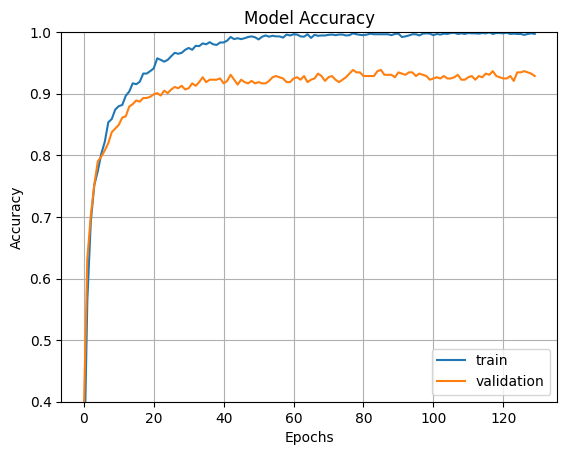

In [ ]:
fig1 = plt.gcf()
plt.plot(history_50.history['accuracy'])
plt.plot(history_50.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

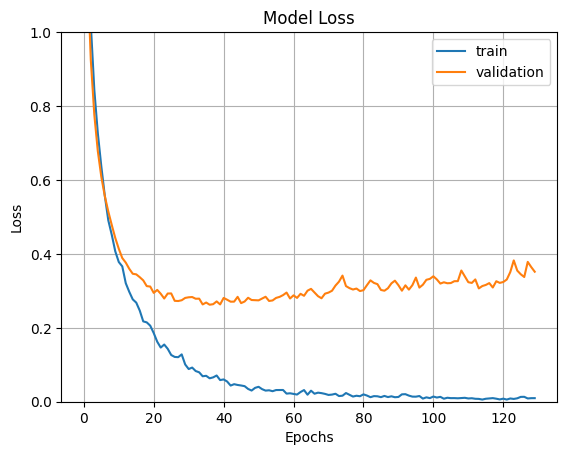

In [ ]:
fig1 = plt.gcf()
plt.plot(history_50.history['loss'])
plt.plot(history_50.history['val_loss'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

101 Resnet

---



In [ ]:
resnet_ml = Sequential()

pretrain = tf.keras.applications.ResNet101(include_top= False,
                                          input_shape=(180,180,3),
                                          pooling='avg', classes=6,
                                          )


resnet_ml.add(pretrain)
# resnet_ml.add(Flatten())
resnet_ml.add(Flatten())
resnet_ml.add(Dense(units=1024, activation='relu'))  # use ReLU activation function

resnet_ml.add(Dense(units=128, activation='relu')) # use ReLU activation function

resnet_ml.add(Dense(6, activation='softmax'))

In [ ]:
resnet_ml.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                                 
Total params: 44888326 (171.24 MB)
Trainable params: 44782982 (170.83 MB)
Non-trainable params: 105344 (411.50 KB)
_________________________________________________________________


Training the complete model

In [ ]:
resnet_ml.optimizer.get_config()["name"]

In [ ]:
checkpoint_path = "/content/drive/MyDrive/resnet_101_updated_lr_2g_wtl.h5"
model_checkpoint_full = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [ ]:


resnet_ml.compile(optimizer=Adam(learning_rate=0.0000055), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
resnet_ml.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                                 
Total params: 44888326 (171.24 MB)
Trainable params: 44782982 (170.83 MB)
Non-trainable params: 105344 (411.50 KB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.models import load_model
saved_model_path = "/content/drive/MyDrive/resnet_101_updated_lr_2g_wtl.h5"
best_model_101 = load_model(saved_model_path)

In [ ]:
fig1 = plt.gcf()
plt.plot(history_101.history['accuracy'])
plt.plot(history_101.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
fig1 = plt.gcf()
plt.plot(history_101.history['loss'])
plt.plot(history_101.history['val_loss'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# 152 Resnet

---



In [ ]:
resnet_ml = Sequential()

pretrain = tf.keras.applications.ResNet152(include_top= False,
                                          input_shape=(180,180,3),
                                          pooling='avg', classes=6,
                                          )



resnet_ml.add(pretrain)
# resnet_ml.add(Flatten())
resnet_ml.add(Flatten())
resnet_ml.add(Dense(units=1024, activation='relu'))  # use ReLU activation function

resnet_ml.add(Dense(units=128, activation='relu')) # use ReLU activation function

resnet_ml.add(Dense(6, activation='softmax'))

In [ ]:
resnet_ml.summary()

Training the complete model

In [ ]:
resnet_ml.optimizer.get_config()["name"]

In [ ]:
checkpoint_path = "/content/drive/MyDrive/resnet_152_updated_lr_2g_wtl.h5"
model_checkpoint_full = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [ ]:


resnet_ml.compile(optimizer=Adam(learning_rate=0.0000055), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
resnet_ml.summary()

In [ ]:
epochs=130
history_152 = resnet_ml.fit(
    augmented_train_ds,
    validation_data = val_ds,
    epochs = epochs,
    shuffle = True,
    callbacks=[model_checkpoint_full]
)

In [ ]:
from tensorflow.keras.models import load_model
saved_model_path = "/content/drive/MyDrive/resnet_152_updated_lr_2g_wtl.h5"
best_model_152 = load_model(saved_model_path)

In [ ]:
fig1 = plt.gcf()
plt.plot(history_152.history['accuracy'])
plt.plot(history_152.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
fig1 = plt.gcf()
plt.plot(history_152.history['loss'])
plt.plot(history_152.history['val_loss'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


Prediction and visualiasation


In [ ]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
plt.plot(history_50.history['accuracy'], label='ResNet-50 Training Accuracy')
plt.plot(history_101.history['accuracy'], label='ResNet-101 Training Accuracy')
plt.plot(history_152.history['accuracy'], label='ResNet-152 Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracies of Models - Without Transfer Learning')
plt.show()

# Plot validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(history_50.history['val_accuracy'], label='ResNet-50 Validation Accuracy')
plt.plot(history_101.history['val_accuracy'], label='ResNet-101 Validation Accuracy')
plt.plot(history_152.history['val_accuracy'], label='ResNet-152 Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracies of Models - Without Transfer Learning')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history_50.history['val_loss'], label='ResNet-50 Validation loss')
plt.plot(history_101.history['val_loss'], label='ResNet-101 Validation loss')
plt.plot(history_152.history['val_loss'], label='ResNet-152 Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Validation loss of Models - without transfer learning')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history_50.history['loss'], label='ResNet-50 training loss')
plt.plot(history_101.history['loss'], label='ResNet-101 training loss')
plt.plot(history_152.history['loss'], label='ResNet-152 training loss')

plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training Loss of Models - without transfer learning - 130 epochs')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history_50.history['loss'], label='ResNet-50 training loss')
plt.plot(history_101.history['loss'], label='ResNet-101 training loss')
plt.plot(history_152.history['loss'], label='ResNet-152 training loss')

plt.plot(history_50.history['val_loss'], label='ResNet-50 Validation loss')
plt.plot(history_101.history['val_loss'], label='ResNet-101 Validation loss')
plt.plot(history_152.history['val_loss'], label='ResNet-152 Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Loss of Models - without transfer learning - 130 epochs')
plt.show()

1/1 [==============================] - 3s 3s/step


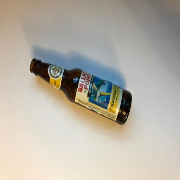

Image: /content/drive/MyDrive/glass477.jpg
Resnet50 Prediction: glass
Resnet101 Prediction: glass
Resnet152 3 Prediction: glass
------------------------------
1/1 [==============================] - 0s 53ms/step


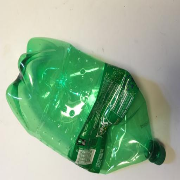

Image: /content/drive/MyDrive/plastic472.jpg
Resnet50 Prediction: plastic
Resnet101 Prediction: plastic
Resnet152 3 Prediction: plastic
------------------------------


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Assuming you have three models named model1, model2, and model3
# Replace these with your actual model instances
model1 = best_model_50
model2 = best_model_101
model3 = best_model_152

# Assuming glass is a list of file paths
imagees = ["/content/drive/MyDrive/glass477.jpg",
         "/content/drive/MyDrive/plastic472.jpg"]

# Define the desired height and width for resizing
img_height, img_width = 180, 180  # Change these dimensions as needed

# Loop through the images
for img_path in imagees:
    # Read the image using OpenCV
    img = cv2.imread(img_path)

    # Check if the image is successfully loaded
    if img is not None:
        # Resize the image
        img_resize = cv2.resize(img, (img_width, img_height))

        # Add an extra dimension to the image to make it compatible with the models
        img = np.expand_dims(img_resize, axis=0)

        # Make predictions using each model
        prediction1 = model1.predict(img)
        prediction2 = model2.predict(img)
        prediction3 = model3.predict(img)

        # Display the image
        cv2_imshow(img_resize)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        # Print or use the predictions as needed
        print(f"Image: {img_path}")
        print("Resnet50 Prediction:", class_names[np.argmax(prediction1)])
        print("Resnet101 Prediction:", class_names[np.argmax(prediction2)])
        print("Resnet152 3 Prediction:", class_names[np.argmax(prediction3)])
        print("-" * 30)
    else:
        print(f"Error: Unable to read the image at path {img_path}.")

In [ ]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
plt.plot(history_50.history['accuracy'], label='ResNet-50 Training Accuracy')
plt.plot(history_101.history['accuracy'], label='ResNet-101 Training Accuracy')
plt.plot(history_152.history['accuracy'], label='ResNet-152 Training Accuracy')
plt.plot(history_50.history['val_accuracy'], label='ResNet-50 Validation Accuracy')
plt.plot(history_101.history['val_accuracy'], label='ResNet-101 Validation Accuracy')
plt.plot(history_152.history['val_accuracy'], label='ResNet-152 Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracies of Models without transfer learning')
plt.show()

# Plot validation accuracies
# plt.figure(figsize=(12, 6))

# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Validation Accuracies of Different Models')
# plt.show()

In [ ]:


# Plot the training and validation accuracy of each model
plt.plot(best_model_50['accuracy'])
plt.plot(best_model_50['val_accuracy'])
plt.plot(best_model_101['accuracy'])
plt.plot(best_model_101['val_accuracy'])
plt.plot(best_model_152['accuracy'])
plt.plot(best_model_152['val_accuracy'])

# Add labels and legend
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet 50 Training', 'Resnet 50 Validation', 'best_model_101 Training', 'best_model_101 Validation', 'best_model_152 Training', 'best_model_152 Validation'], loc='lower right')

# Show the plot
plt.show()

TypeError: ignored

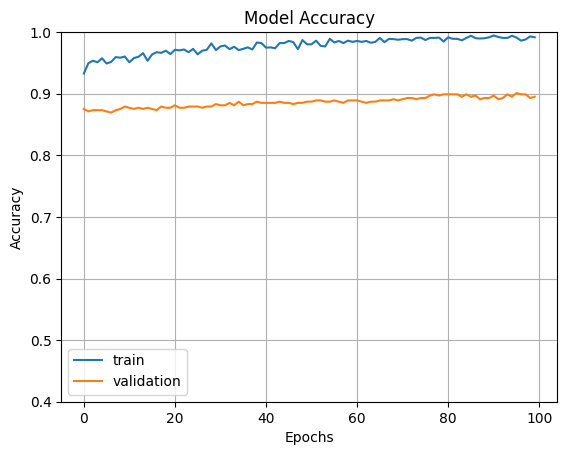

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
import cv2
import numpy as np

# Assuming you have three models named model1, model2, and model3
# Replace these with your actual model instances
model1 = ...
model2 = ...
model3 = ...

# Assuming glass is a list of file paths
glass = ["path/to/image1.jpg", "path/to/image2.jpg", "path/to/image3.jpg",
         "path/to/image4.jpg", "path/to/image5.jpg", "path/to/image6.jpg"]

# Define the desired height and width for resizing
img_height, img_width = 224, 224  # Change these dimensions as needed

# Loop through the images
for img_path in glass:
    # Read the image using OpenCV
    img = cv2.imread(img_path)

    # Check if the image is successfully loaded
    if img is not None:
        # Resize the image
        img_resize = cv2.resize(img, (img_width, img_height))

        # Add an extra dimension to the image to make it compatible with the models
        img = np.expand_dims(img_resize, axis=0)

        # Make predictions using each model
        prediction1 = model1.predict(img)
        prediction2 = model2.predict(img)
        prediction3 = model3.predict(img)

        # Display the image
        cv2.imshow("Image", img_resize)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        # Print or use the predictions as needed
        print(f"Image: {img_path}")
        print("Model 1 Prediction:", prediction1)
        print("Model 2 Prediction:", prediction2)
        print("Model 3 Prediction:", prediction3)
        print("-" * 30)
    else:
        print(f"Error: Unable to read the image at path {img_path}.")

In [ ]:
import cv2
import numpy as np
img = cv2.imread(str(glass[110]))
img_resize =cv2.resize(img, (img_height, img_width))
img = np.expand_dims(img_resize, axis=0)
print(img.shape)

(1, 180, 180, 3)


In [ ]:
pred = best_model_1.predict(img)
print(pred)

1/1 [==============================] - 1s 1s/step
[[2.15828695e-04 7.31977940e-01 1.78654239e-01 7.84617066e-02
  1.06358435e-02 5.44596114e-05]]


In [ ]:

final_pred = class_names[np.argmax(pred)]

In [ ]:


final_pred

'glass'

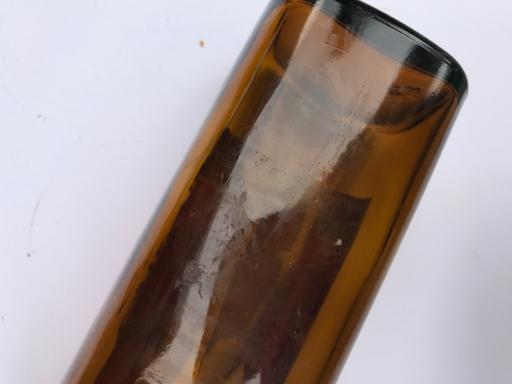

In [ ]:
PIL.Image.open(str(glass[110]))